In [17]:
import os
from pathlib import Path
from tqdm import tqdm
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw, ImageOps
import numpy as np
from IPython.display import display
import IPython.display

%run utils.ipynb

In [18]:
config = Config()

In [19]:
%%time
image_fnames = []

for (dir_path, dir_names, fnames) in os.walk(config.dataset_source):
    image_fnames.extend(map(lambda fn: os.path.join(dir_path, fn), fnames))

print(f'Found {len(image_fnames)} images under "{config.dataset_source}"')

Found 9145 images under "dataset_source/101_ObjectCategories"
CPU times: user 7.71 ms, sys: 0 ns, total: 7.71 ms
Wall time: 7.45 ms


In [20]:
print(f'Start making {config.dataset_sample_count} sample images from scratch under "{config.dataset_path}"')

Start making 3000 sample images from scratch under "dataset"


In [21]:
%%time
if not os.path.exists(config.dataset_path):
    print(f'Creating "{config.dataset_path}"')
    os.mkdir(config.dataset_path)
else:
    print(f'Cleaning "{config.dataset_path}"')
    removed = 0
    
    for fn in os.listdir(config.dataset_path):
        if fn.endswith(".png"):
            os.remove(os.path.join(config.dataset_path, fn))
            removed += 1

    print(f'Removed {removed} samples under "{config.dataset_path}"')

Cleaning "dataset"
Removed 0 samples under "dataset"
CPU times: user 562 μs, sys: 0 ns, total: 562 μs
Wall time: 402 μs


In [22]:
def preprocess_image(img):
    a = img.convert('L')
    b = a.filter(ImageFilter.SMOOTH)
    c = ImageEnhance.Sharpness(b).enhance(0.5)
    d = c.filter(ImageFilter.CONTOUR)
    e = ImageOps.invert(d)
    return e

In [23]:
def extract_random_square(img, square_size):
    if img.width >= square_size and img.height >= square_size:
        offsets = np.random.normal(0, 1/3, 2)
        offsets = np.clip(offsets, -1, 1)
    else:
        offsets = (0, 0)
        
    half_img_width = img.width // 2
    half_img_height = img.height // 2
    half_square_size = square_size // 2
    offset_space_x = half_img_width - half_square_size
    offset_space_y = half_img_height - half_square_size
    square_center = (
        half_img_width + int(offset_space_x * offsets[0]),
        half_img_height + int(offset_space_y * offsets[0])
    )
    square_coords = (
        square_center[0] - half_square_size,
        square_center[1] - half_square_size,
        square_center[0] + half_square_size,
        square_center[1] + half_square_size
    )
    return img.crop(square_coords), square_center

In [24]:
for i in tqdm(range(config.dataset_sample_count)):
    fname_i = i % len(image_fnames)
    fname = image_fnames[fname_i]
    
    with Image.open(fname) as source_img:
        source_img1 = preprocess_image(source_img)
        sample_img, center_coords = extract_random_square(source_img1, config.kernel_size)
        fname_stem = Path(fname).stem
        fname_prefix = os.path.dirname(fname).replace(os.path.sep, '_')        
        sample_img_fname = os.path.join(config.dataset_path, f'{fname_prefix}_{fname_stem}@{center_coords[0]},{center_coords[1]}.png')
        sample_img.save(sample_img_fname, format='png')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:04<00:00, 724.23it/s]


Image index 2780 dataset_source/101_ObjectCategories/beaver/image_0013.jpg



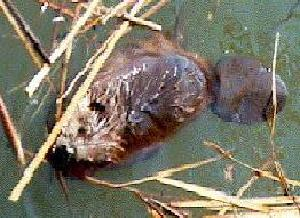
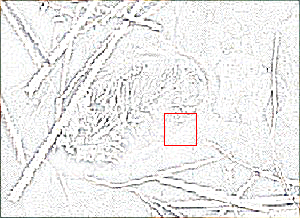
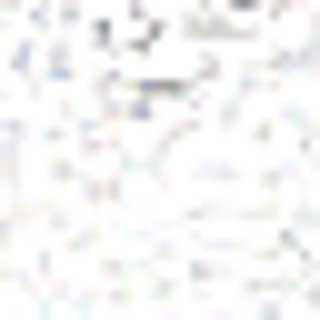

In [25]:
assert len(image_fnames) > 0
i = np.random.randint(len(image_fnames))

print(f'Image index {i} {image_fnames[i]}')
img = Image.open(image_fnames[i])
#display(img)
#display(img.filter(ImageFilter.CONTOUR))

img1 = ImageEnhance.Sharpness(img.filter(ImageFilter.SMOOTH)).enhance(0.5).filter(ImageFilter.CONTOUR)
#display(img1)


# display(img.filter(ImageFilter.SMOOTH).filter(ImageFilter.CONTOUR))
#display(img.filter(ImageFilter.SMOOTH).filter(ImageFilter.FIND_EDGES))
img2 = None

if img1.width >= config.kernel_size and img1.height >= config.kernel_size:
    offsets = np.random.normal(0, 1/3, 2)
    offsets = np.clip(offsets, -1, 1)
    half_img_width = img1.width // 2
    half_img_height = img1.height // 2
    half_kernel_size = config.kernel_size // 2
    offset_space_x = half_img_width - half_kernel_size
    offset_space_y = half_img_height - half_kernel_size
    patch_center = (
        half_img_width + offset_space_x * offsets[0],
        half_img_height + offset_space_y * offsets[0]
    )
    
    patch_coords = (
        patch_center[0] - half_kernel_size,
        patch_center[1] - half_kernel_size,
        patch_center[0] + half_kernel_size,
        patch_center[1] + half_kernel_size
    )
    img2 = img1.crop(patch_coords).resize((320, 320))
    ImageDraw.Draw(img1).rectangle(patch_coords, outline='red')

utils.display_images([img, img1, img2])